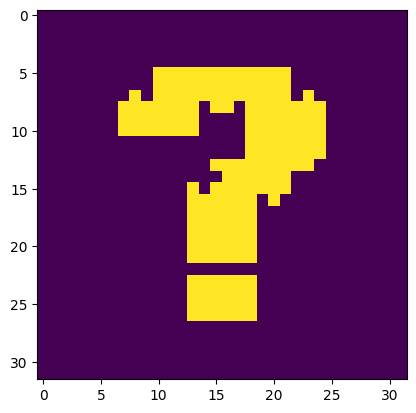

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

'''
First load in the substrate and visualise it
'''

substrate = np.load('data/toy_examples/question_mark_substrate.npy')

plt.imshow(substrate)

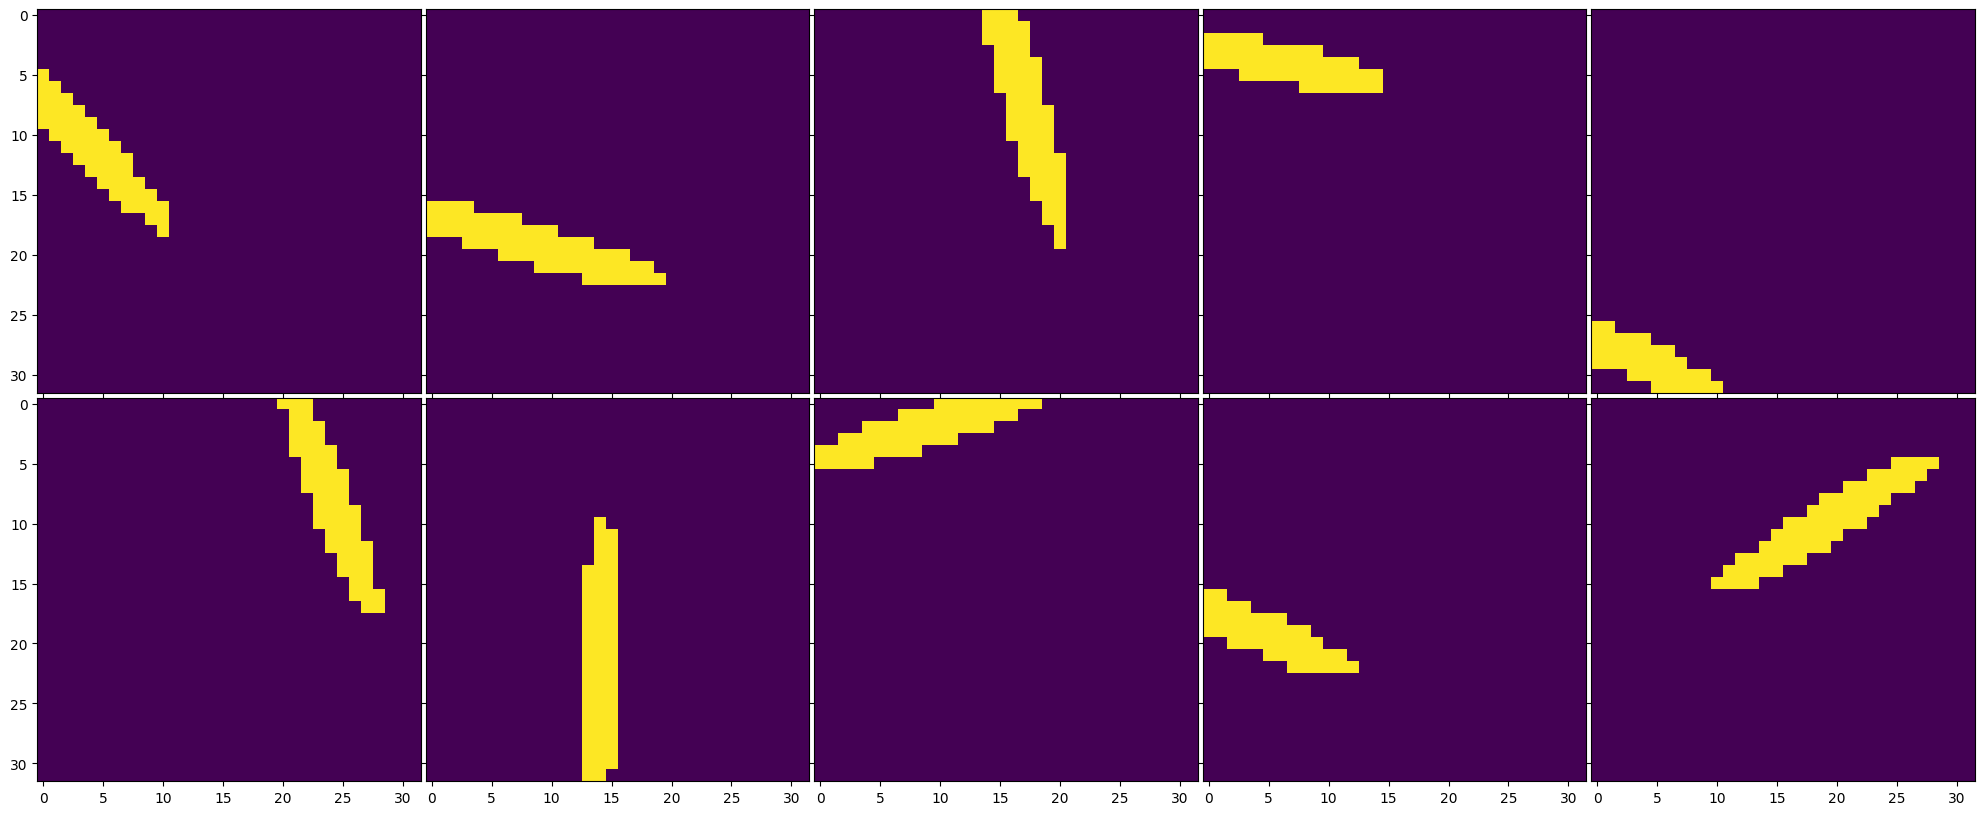

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid

'''
Load in 1000 32x32 lesions, that are basically just ellipsoids
'''

lesions = np.load('data/toy_examples/1000_lesions.npy')

# Let's visualise a few
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 5),
                 axes_pad=0.05,
                 share_all=True
                 )

for i in range(10):
    grid[i].imshow(lesions[i])

(array([606.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 394.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

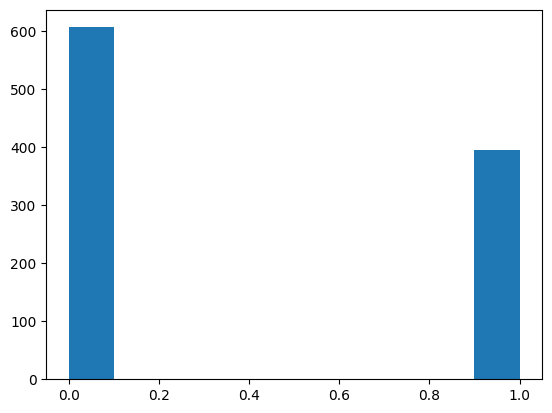

In [3]:
# LET'S SIMULATE SOME BINARY SCORES

# Threshold after which there is deficit
BINARY_THRESHOLD = 0.05

deficit_scores = [0 for i in range(len(lesions))]
positive_indices = []
for i in range(len(lesions)):
    overlap = lesions[i] * substrate
    counts = np.count_nonzero(overlap)
    voxels_gt = np.sum(substrate)
    ratio_lesion = counts / voxels_gt

    if ratio_lesion > BINARY_THRESHOLD:
        deficit_scores[i] = 1 
    else:
        deficit_scores[i] = 0
                
deficit_scores = np.array(deficit_scores)
plt.hist(deficit_scores)

In [4]:
from sklearn.model_selection import train_test_split

# WE NEED TO ADD ONE EXTRA CHANNEL AS DL MODELS EXPECT A COLOUR CHANNEL
lesions = np.expand_dims(lesions, axis=1)

# FIRST SPLIT INTO 90/10
train_data, vc_data, train_labels, vc_labels = train_test_split(lesions,
                                                                deficit_scores,
                                                                test_size=0.1)

# THEN SPLIT THE REMAINING 10% INTO VALIDATION AND CALIBRATION - 50/50
val_data, cal_data, val_labels, cal_labels = train_test_split(vc_data,
                                                              vc_labels,
                                                              test_size=0.5)

train_data.shape, val_data.shape, cal_data.shape

((900, 1, 32, 32), (50, 1, 32, 32), (50, 1, 32, 32))

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# class DeficitDataset(Dataset):

#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         img = self.data[index]
#         return img, np.expand_dims(self.labels[index], axis=0)
    
    
class DeficitDataset(Dataset):
    """
    Dataset that holds tensors already on GPU.
    Works perfectly with DataLoader!
    """
    def __init__(self, data, labels, device):
        # Convert to tensors and move to GPU
        if isinstance(data, np.ndarray):
            self.data = torch.tensor(data, dtype=torch.float32, device=device)
        else:
            self.data = data.to(device)
            
        print(self.data.shape)
            
        if isinstance(labels, np.ndarray):
            self.labels = torch.tensor(labels, dtype=torch.float32, device=device)
        else:
            self.labels = labels.to(device)
        
        if self.labels.dim() == 1:
            self.labels = self.labels.unsqueeze(1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        """
        DataLoader will call this method.
        Since data is already on GPU, this just returns GPU tensors!
        """
        return self.data[index], self.labels[index]

batch_size = 64

# CREATE DATA LOADERS
# TRAINING
dataset = DeficitDataset(data=train_data, labels=train_labels, device=device)
train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=False)

# VALIDATION
val_dataset = DeficitDataset(data=val_data, labels=val_labels, device=device)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=False)

# CALIBRATION
# cal_dataset = DeficitDataset(data=cal_data, labels=cal_labels)
# cal_loader = DataLoader(cal_dataset, batch_size=batch_size, drop_last=False,
#                                             shuffle=True, num_workers=10, pin_memory=True)


Using device: cuda:0
torch.Size([900, 1, 32, 32])
torch.Size([50, 1, 32, 32])


In [8]:
def dice_loss(pred_logits, target, eps=1e-6):
            pred = torch.sigmoid(pred_logits)
            num = 2*(pred*target).sum(dim=(1,2,3))
            den = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps
            return 1 - (num/den).mean()
        
def focal_loss(pred_logits, target, alpha=0.25, gamma=2.0):
    pred_probs = torch.sigmoid(pred_logits)

    # For positive samples (target=1)
    p_t = pred_probs * target + (1 - pred_probs) * (1 - target)
    # Focal weight: (1 - p_t)^gamma
    focal_weight = (1 - p_t) ** gamma
    # BCE component
    bce = F.binary_cross_entropy_with_logits(pred_logits, target, reduction='none')

    # Alpha weighting
    alpha_t = alpha * target + (1 - alpha) * (1 - target)
    # Combine
    loss = alpha_t * focal_weight * bce
    return loss.mean()

def tversky_loss(pred_logits, target, alpha=0.7, beta=0.3, eps=1e-6):
    pred = torch.sigmoid(pred_logits)
    
    # True positives
    tp = (pred * target).sum(dim=(1,2,3))
    # False negatives (missed lesion pixels)
    fn = ((1 - pred) * target).sum(dim=(1,2,3))
    # False positives (predicted lesions where there are none)
    fp = (pred * (1 - target)).sum(dim=(1,2,3))
    # Tversky index
    tversky = tp / (tp + alpha * fn + beta * fp + eps)
    
    return 1 - tversky.mean()


def combo_loss(pred_logits, target, 
               focal_weight=0.5, tversky_weight=0.5,
               focal_alpha=0.25, focal_gamma=2.0,
               tversky_alpha=0.7, tversky_beta=0.3):
    """
    Combination of Focal Loss and Tversky Loss.
    
    Recommended weights for sparse lesions:
    - focal_weight=0.6, tversky_weight=0.4
    """
    f_loss = focal_loss(pred_logits, target, alpha=focal_alpha, gamma=focal_gamma)
    t_loss = tversky_loss(pred_logits, target, alpha=tversky_alpha, beta=tversky_beta)
    
    return focal_weight * f_loss + tversky_weight * t_loss

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ConditionalDiffusionLDM_HighDiversity(nn.Module):
    """
    Enhanced version with techniques to improve sample diversity:
    1. Temperature scaling
    2. Classifier-free guidance
    3. Stochastic sampling
    4. Dropout during inference
    """
    def __init__(self,
                 input_size,
                 sd=16,
                 in_chans=1,
                 timesteps=100,
                 schedule='cosine',
                 dropout=0.1):  # Add dropout for stochasticity
        super().__init__()
        self.in_chans = in_chans
        self.timesteps = timesteps
        self.input_size = input_size
        self.dropout = dropout

        # schedule
        if schedule == 'cosine':
            alphas = self._cosine_schedule(timesteps)
        else:
            alphas = self._linear_schedule(timesteps)
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)

        # time embed
        self.time_embed_dim = sd * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(sd),
            nn.Linear(sd, self.time_embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),  # Add dropout
            nn.Linear(self.time_embed_dim, self.time_embed_dim),
        )

        # y embed with dropout for stochasticity
        self.y_mlp = nn.Sequential(
            nn.Linear(1, self.time_embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(self.time_embed_dim, self.time_embed_dim),
        )

        # denoiser
        self._build_denoiser(in_chans, sd, self.time_embed_dim, dropout)

    def _cosine_schedule(self, timesteps, s=0.008):
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        return torch.clip(alphas, 0.001, 0.999)

    def _linear_schedule(self, timesteps, beta_start=0.0001, beta_end=0.02):
        betas = torch.linspace(beta_start, beta_end, timesteps)
        return 1.0 - betas

    def _build_denoiser(self, in_chans, sd, time_dim, dropout):
        channels = [in_chans, sd, sd*2, sd*4, sd*4]
        self.downs = nn.ModuleList([
            SBlock(channels[i], channels[i+1], downsample=True, 
                   add_coords=False, dropout=dropout)
            for i in range(len(channels)-1)
        ])
        self.time_proj = nn.ModuleList([
            nn.Sequential(
                nn.GELU(), 
                nn.Dropout(dropout),
                nn.Linear(time_dim, channels[i+1])
            )
            for i in range(len(channels)-1)
        ])
        self.ups = nn.ModuleList([
            SBlock(channels[i+1] * 2, channels[i], upsample=True, dropout=dropout)
            for i in range(len(channels)-2, -1, -1)
        ])
        self.final_conv = nn.Conv2d(channels[0], 1, 1)

    def q_sample(self, x_0, t):
        """Forward (corruption) for binary lesion maps."""
        batch_size = x_0.shape[0]
        alpha_t = self.alphas_cumprod[t].view(batch_size, 1, 1, 1)
        alpha_t = torch.clamp(alpha_t, 0.0, 1.0)
        
        keep_mask = (torch.rand_like(x_0) < alpha_t.expand_as(x_0)).float()
        random_bits = (torch.rand_like(x_0) > 0.5).float()

        x_t = x_0 * keep_mask + random_bits * (1 - keep_mask)
        return x_t

    def predict_x0(self, x_t, t, y, cfg_scale=0.0):
        """
        Predict lesion logits with optional classifier-free guidance.
        
        Args:
            cfg_scale: Classifier-free guidance scale (0 = no guidance, higher = stronger conditioning)
        """
        if y.dim() == 1:
            y = y.unsqueeze(1).float()
        
        # Standard conditional prediction
        t_emb = self.time_mlp(t)
        y_emb = self.y_mlp(y)
        cond_emb = t_emb + y_emb

        x = x_t
        skips = []
        for down, proj in zip(self.downs, self.time_proj):
            x = down(x)
            x = x + proj(cond_emb)[:, :, None, None]
            skips.append(x)

        for up in self.ups:
            x = torch.cat([x, skips.pop()], dim=1)
            x = up(x)

        output_cond = self.final_conv(x)
        
        # Classifier-free guidance (if enabled)
        if cfg_scale > 0.0 and self.training == False:
            # Unconditional prediction (y=0 for all)
            y_uncond = torch.zeros_like(y)
            t_emb_uncond = self.time_mlp(t)
            y_emb_uncond = self.y_mlp(y_uncond)
            cond_emb_uncond = t_emb_uncond + y_emb_uncond
            
            x_uncond = x_t
            skips_uncond = []
            for down, proj in zip(self.downs, self.time_proj):
                x_uncond = down(x_uncond)
                x_uncond = x_uncond + proj(cond_emb_uncond)[:, :, None, None]
                skips_uncond.append(x_uncond)
            
            for up in self.ups:
                x_uncond = torch.cat([x_uncond, skips_uncond.pop()], dim=1)
                x_uncond = up(x_uncond)
            
            output_uncond = self.final_conv(x_uncond)
            
            # Guidance formula: output = uncond + scale * (cond - uncond)
            output = output_uncond + cfg_scale * (output_cond - output_uncond)
        else:
            output = output_cond
        
        return output

    def p_sample(self, x_t, t, y, temperature=1.0, cfg_scale=0.0):
        """
        Single reverse step with diversity controls.
        
        Args:
            temperature: Controls randomness (higher = more diverse)
            cfg_scale: Classifier-free guidance scale
            stochastic: Whether to use stochastic sampling (True = more diverse)
        """
        lesion_logits = self.predict_x0(x_t, t, y, cfg_scale=cfg_scale)
        
        # Apply temperature scaling
        lesion_logits = lesion_logits / temperature
        
        x0_probs = F.sigmoid(lesion_logits)

        if (t == 0).all():
            return x0_probs

        batch_size = x_t.shape[0]
        alpha_t = self.alphas_cumprod[t].view(batch_size, 1, 1, 1)
        alpha_t_minus_1 = self.alphas_cumprod[t-1].view(batch_size, 1, 1, 1)

        x0_probs = torch.clamp(x0_probs, 0.0, 1.0)
        x0_sample = torch.bernoulli(x0_probs)
        
        flip_prob = torch.clamp(1 - (alpha_t_minus_1 / alpha_t), 0.0, 1.0)
        flip_mask = torch.bernoulli(flip_prob.expand_as(x0_sample))
            
        x_t_minus_1 = x0_sample * (1 - flip_mask) + (1 - x0_sample) * flip_mask
        return x_t_minus_1

    @torch.no_grad()
    def p_sample_loop(self, shape, y, temperature=1.0, cfg_scale=0.0,
                      dropout_during_inference=False):
        """
        Sample with diversity controls.
        
        Args:
            temperature: 0.5-2.0 (higher = more diverse)
            cfg_scale: 0-3.0 (guidance strength, 0 = off)
            stochastic: True for maximum diversity
            dropout_during_inference: True to keep dropout on during sampling
        """
        device = next(self.parameters()).device
        x = torch.bernoulli(torch.ones(shape, device=device) * 0.5)
        
        # Optionally keep dropout enabled during inference for stochasticity
        if dropout_during_inference:
            self.train()  # Enable dropout
        
        for i in reversed(range(self.timesteps)):
            t = torch.full((shape[0],), i, device=device, dtype=torch.long)
            x = self.p_sample(x, t, y, temperature=temperature, 
                            cfg_scale=cfg_scale)
        
        if dropout_during_inference:
            self.eval()  # Restore eval mode
            
        return x

    def forward(self, x, y, val=False, t=None, generate_recon=False):
        """Training forward pass."""
        batch_size = x.shape[0]
        device = x.device

        t_diffusion = torch.randint(0, self.timesteps, (batch_size,), device=device).long()
        x_t = self.q_sample(x, t_diffusion)

        lesion_logits = self.predict_x0(x_t, t_diffusion, y, cfg_scale=0.0)

        # dice = dice_loss(lesion_logits, x)
        loss = combo_loss(lesion_logits, x)

        return {
            'loss': loss
        }


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None].float() * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SBlock(nn.Module):
    def __init__(self, in_planes, planes, downsample=False, ks=3, stride=1, 
                 upsample=False, add_coords=False, dropout=0.0):
        super().__init__()
        self.downsample = downsample
        self.upsample = upsample
        if ks == 3:
            pad = 1
        elif ks == 5:
            pad = 2
        else:
            pad = 3
        if add_coords:
            in_planes += 2
            
        self.c1 = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=ks, stride=stride, padding=pad),
            nn.BatchNorm2d(planes),
            nn.GELU(),
            # nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        )
        self.upsample_layer = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        out = self.c1(x)
        if self.downsample:
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        if self.upsample:
            out = self.upsample_layer(out)
        return out

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR

input_size = 32  # Your image size
model = ConditionalDiffusionLDM_HighDiversity(input_size=32,
                                              sd=16,
                                              timesteps=100,
                                              schedule='cosine',
                                              dropout=0.1  # Important for diversity!
                                            ).to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=3000,      # Total number of epochs
    eta_min=1e-6     # Minimum LR (decays from 3e-4 → 1e-6)
)

Epoch: 0, loss: 0.4668
Best: loss=0.4668, epoch=0


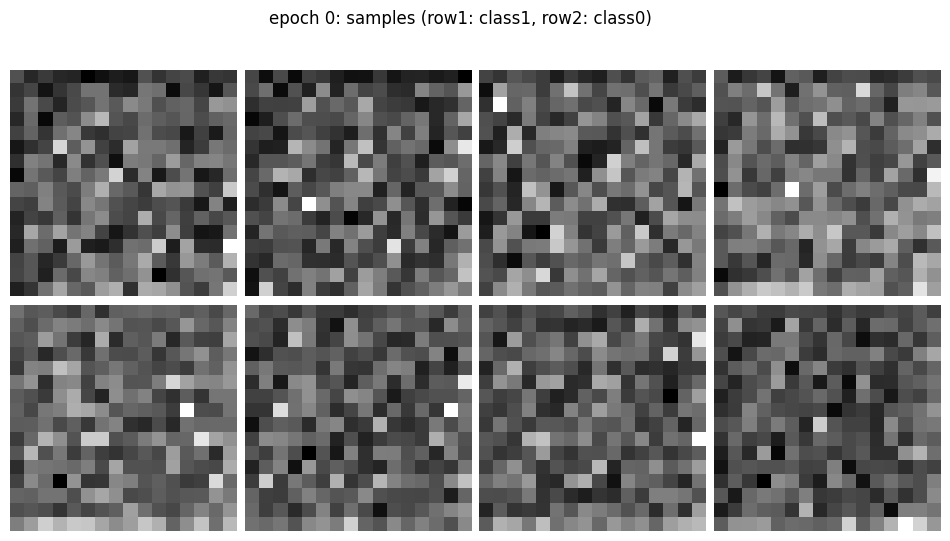

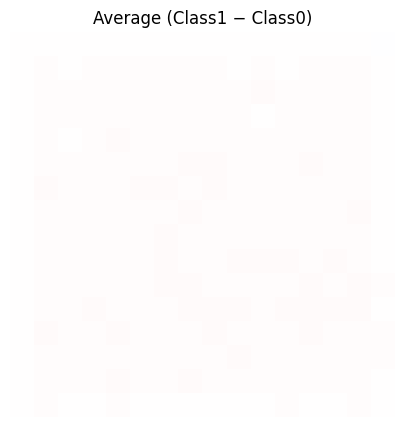

Epoch: 50, loss: 0.3945
Epoch: 100, loss: 0.3963
Best: loss=0.3800, epoch=87
Epoch: 150, loss: 0.3806
Epoch: 200, loss: 0.3751
Best: loss=0.3639, epoch=196


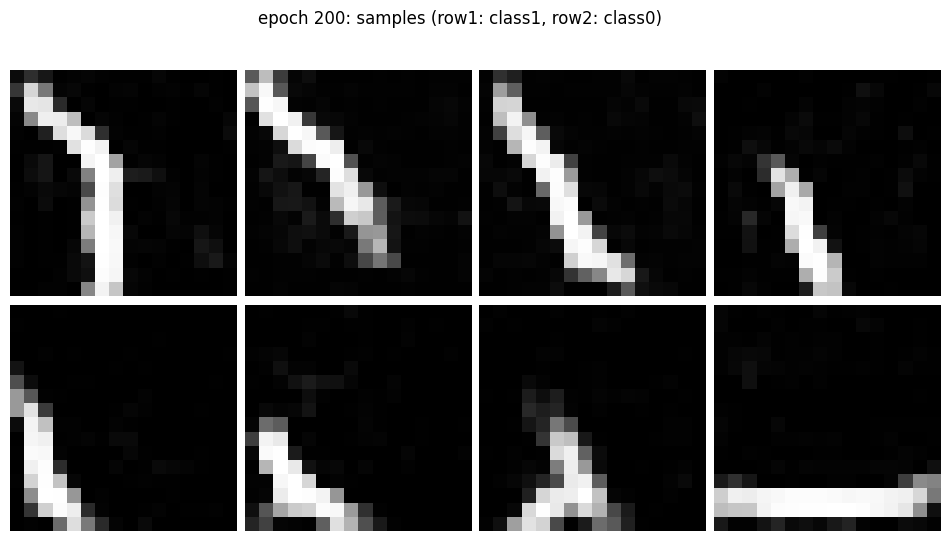

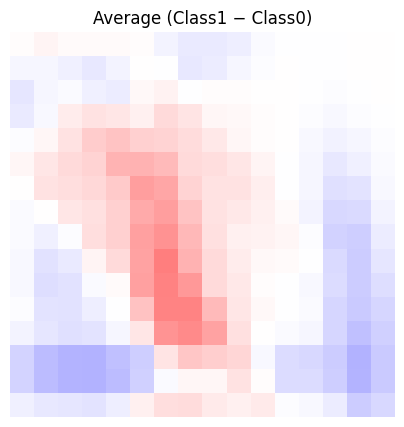

Epoch: 250, loss: 0.3744
Epoch: 300, loss: 0.3709
Best: loss=0.3527, epoch=288
Epoch: 350, loss: 0.3395
Epoch: 400, loss: 0.3560
Best: loss=0.3353, epoch=367


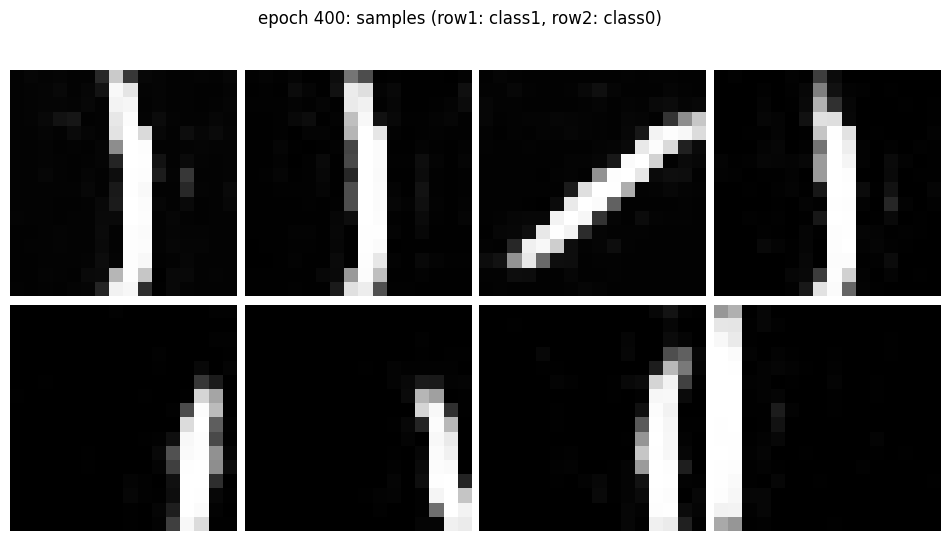

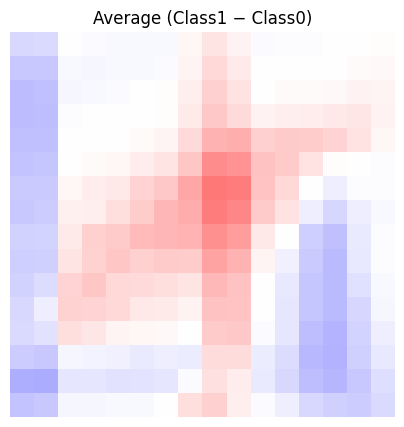

Epoch: 450, loss: 0.3498
Epoch: 500, loss: 0.3663
Best: loss=0.3249, epoch=451
Epoch: 550, loss: 0.3338
Epoch: 600, loss: 0.3332
Best: loss=0.3108, epoch=509


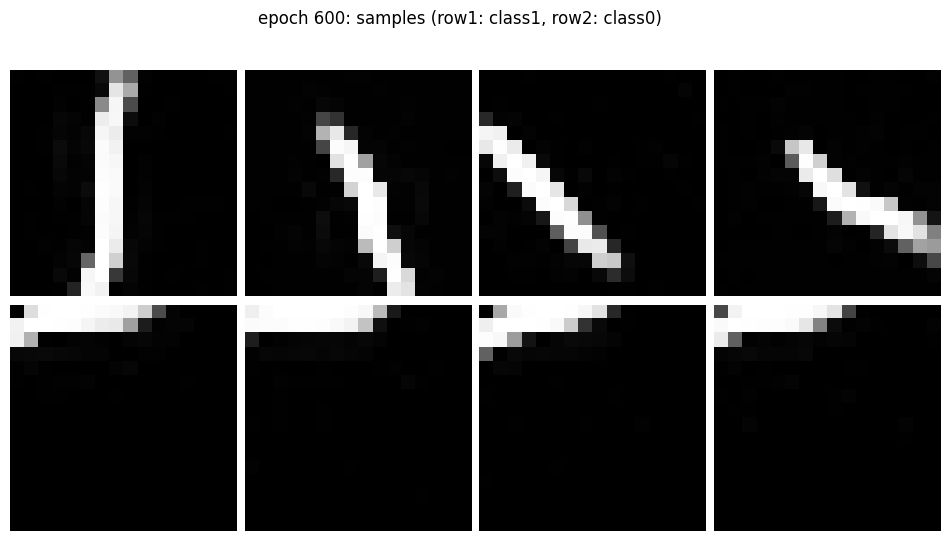

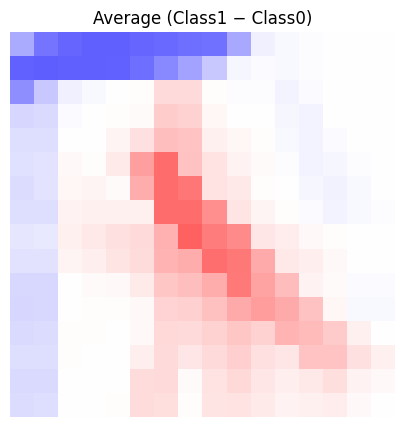

Epoch: 650, loss: 0.3376
Epoch: 700, loss: 0.3056
Best: loss=0.3020, epoch=653
Epoch: 750, loss: 0.3175
Epoch: 800, loss: 0.3206
Best: loss=0.2954, epoch=756


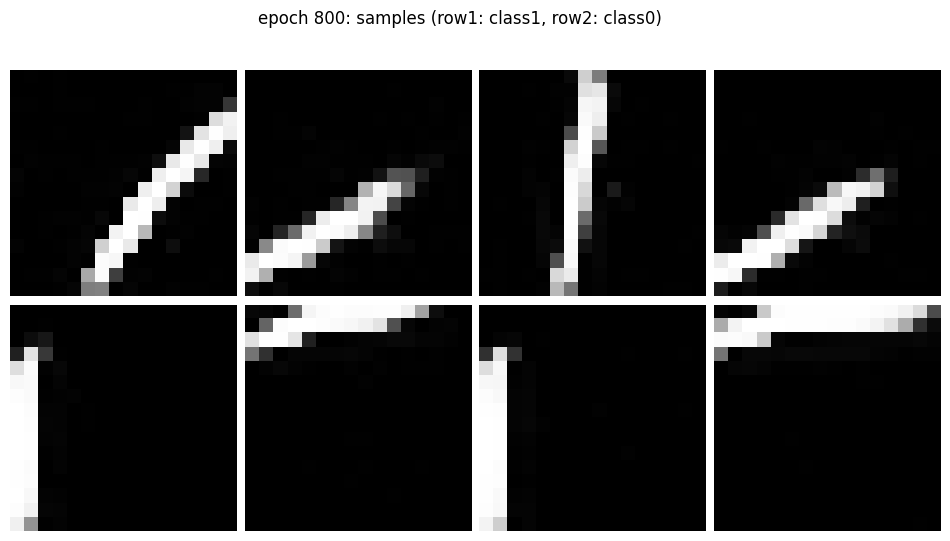

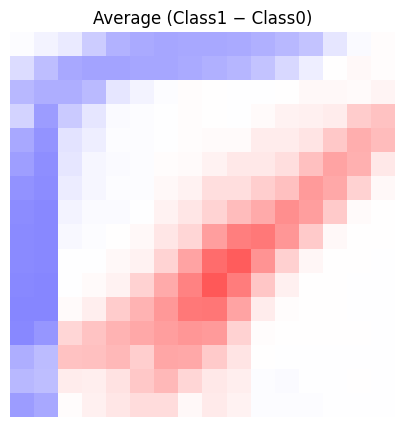

Epoch: 850, loss: 0.3148
Epoch: 900, loss: 0.3293
Best: loss=0.2889, epoch=899
Epoch: 950, loss: 0.3071
Epoch: 1000, loss: 0.3051
Best: loss=0.2650, epoch=985


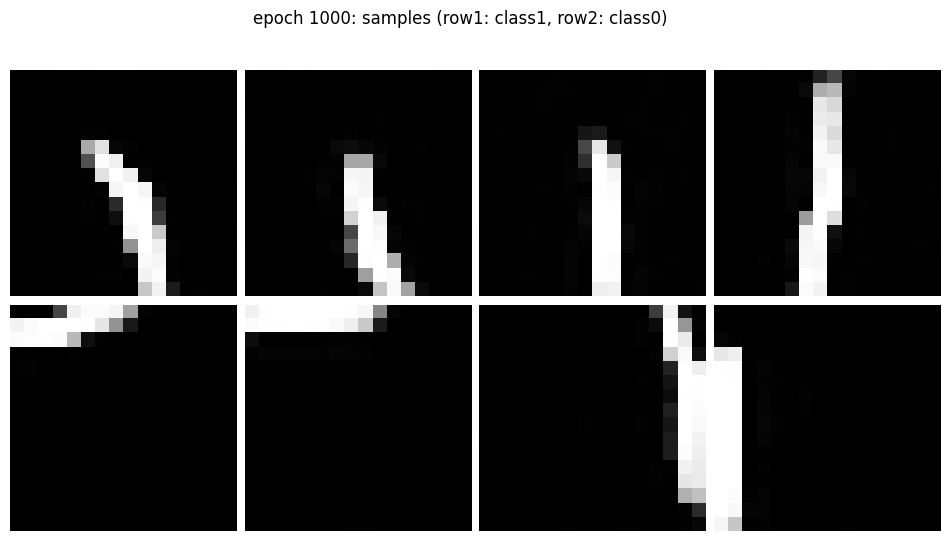

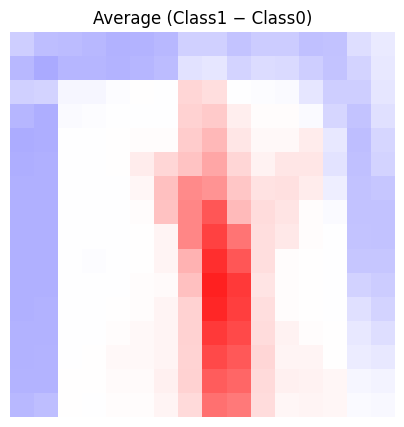

Epoch: 1050, loss: 0.2660
Epoch: 1100, loss: 0.2926
Best: loss=0.2604, epoch=1052
Epoch: 1150, loss: 0.2872
Epoch: 1200, loss: 0.2992
Best: loss=0.2522, epoch=1198


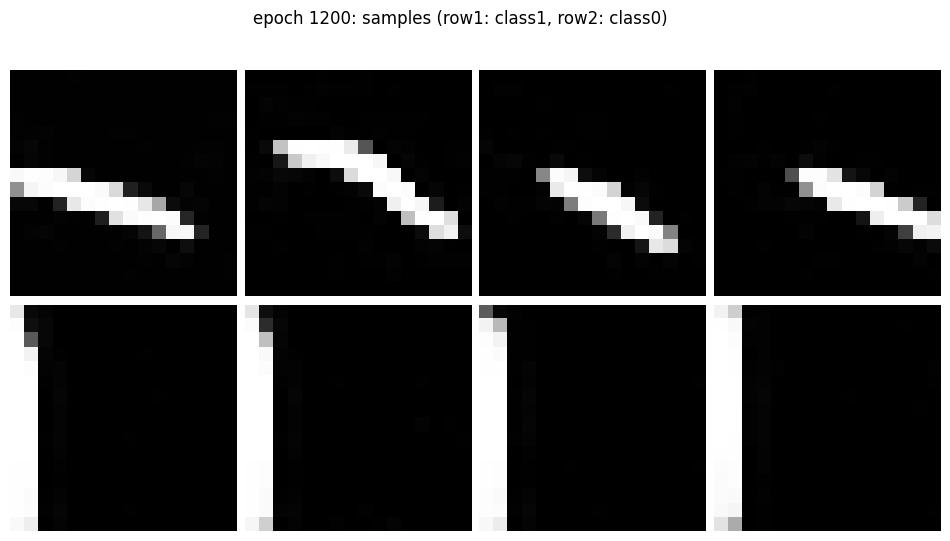

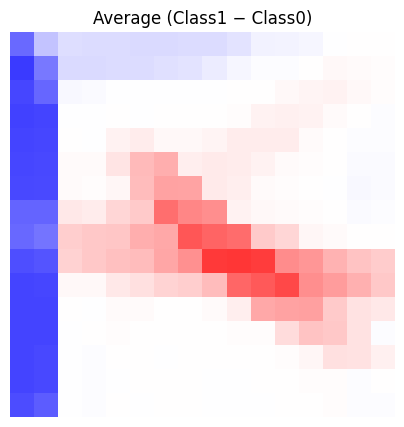

Epoch: 1250, loss: 0.2801
Epoch: 1300, loss: 0.2938
Best: loss=0.2518, epoch=1279
Epoch: 1350, loss: 0.2895
Epoch: 1400, loss: 0.2912
Best: loss=0.2518, epoch=1279


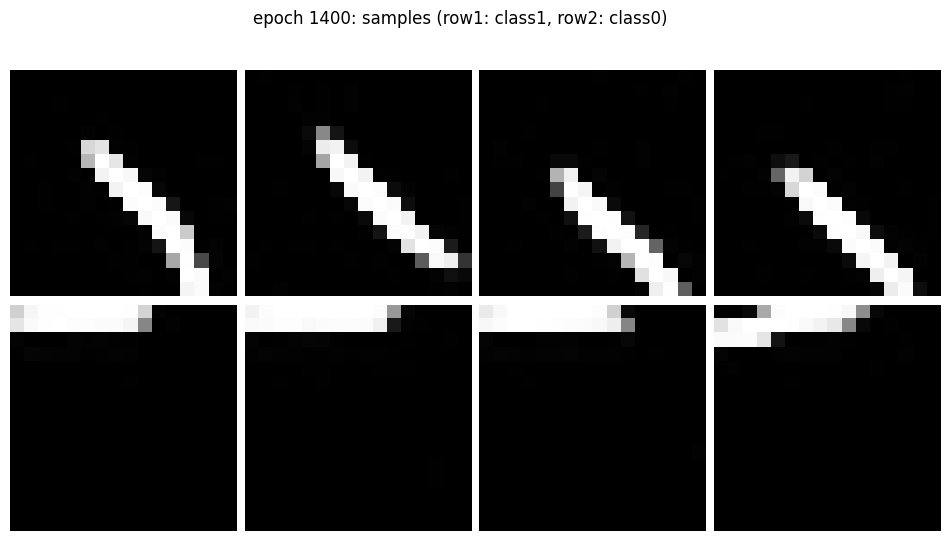

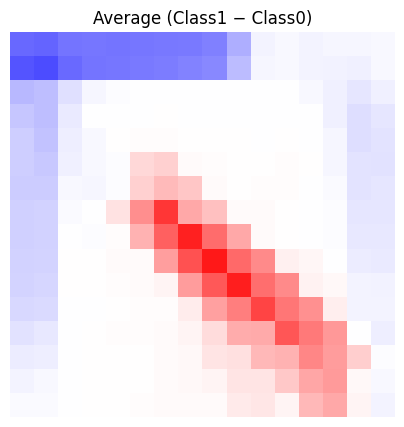

Epoch: 1450, loss: 0.2949
Epoch: 1500, loss: 0.2802
Best: loss=0.2425, epoch=1430
Epoch: 1550, loss: 0.2900
Epoch: 1600, loss: 0.2989
Best: loss=0.2395, epoch=1514


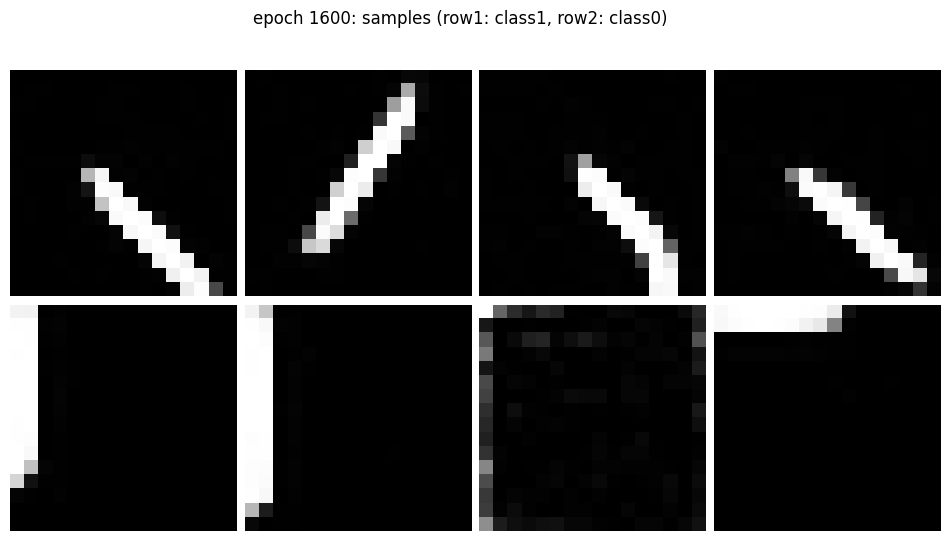

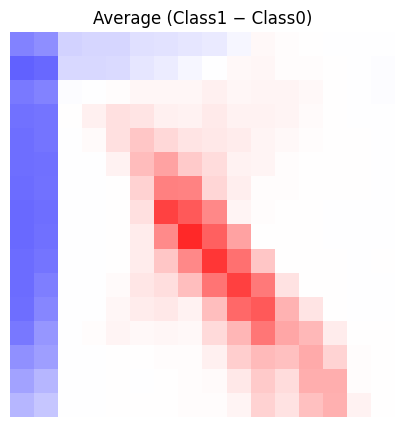

Epoch: 1650, loss: 0.2758
Epoch: 1700, loss: 0.2867
Best: loss=0.2313, epoch=1621
Epoch: 1750, loss: 0.2637
Epoch: 1800, loss: 0.2697
Best: loss=0.2250, epoch=1775


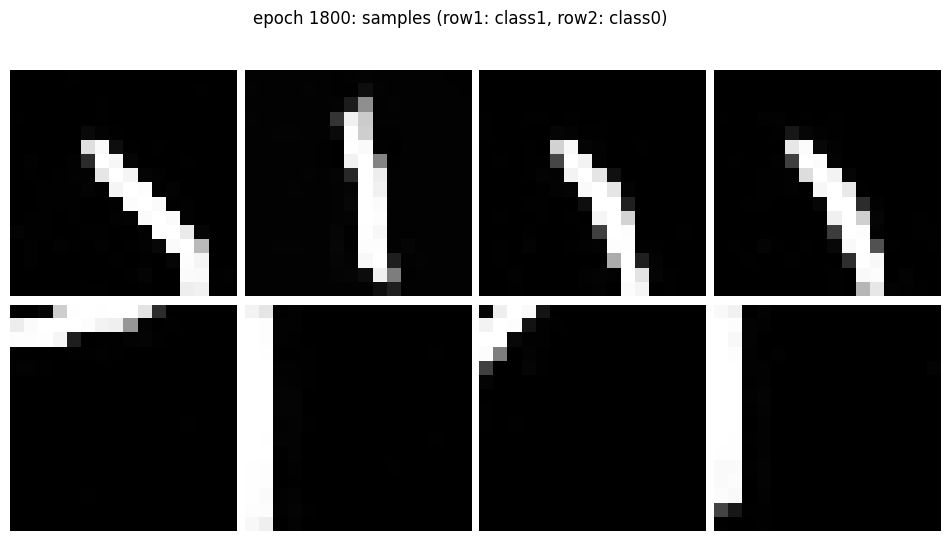

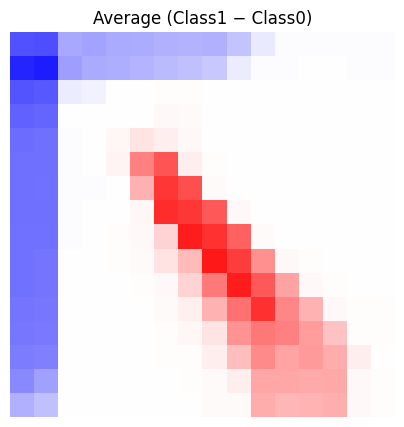

Epoch: 1850, loss: 0.2630
Epoch: 1900, loss: 0.2385
Best: loss=0.2210, epoch=1874
Epoch: 1950, loss: 0.2562
Epoch: 2000, loss: 0.2492
Best: loss=0.2210, epoch=1874


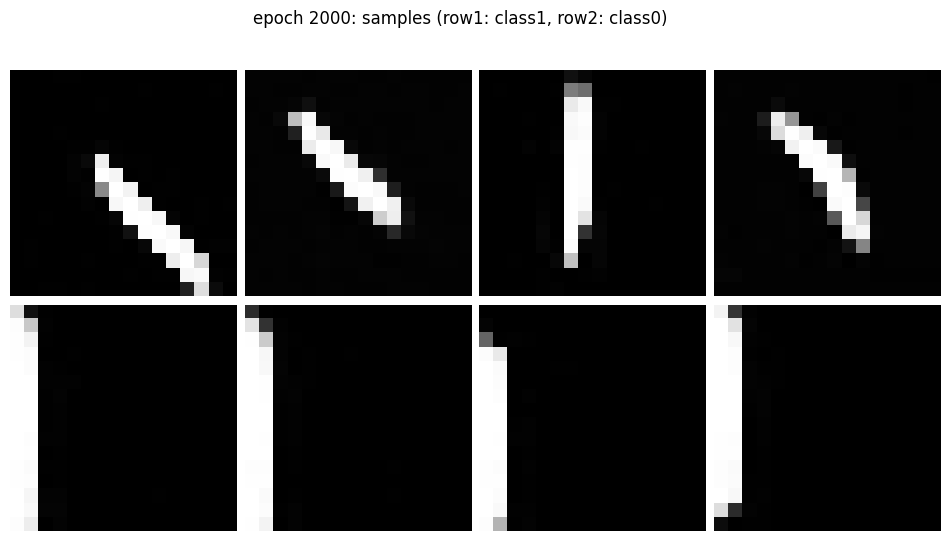

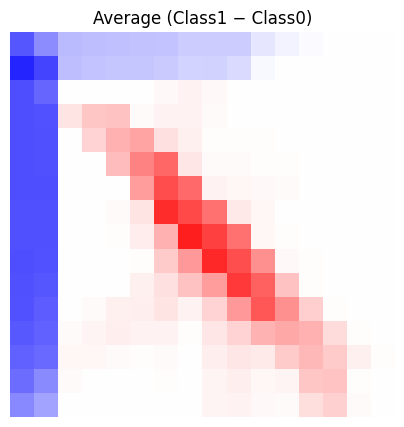

Epoch: 2050, loss: 0.2850
Epoch: 2100, loss: 0.2704
Best: loss=0.2207, epoch=2092
Epoch: 2150, loss: 0.2490
Epoch: 2200, loss: 0.2403
Best: loss=0.2128, epoch=2141


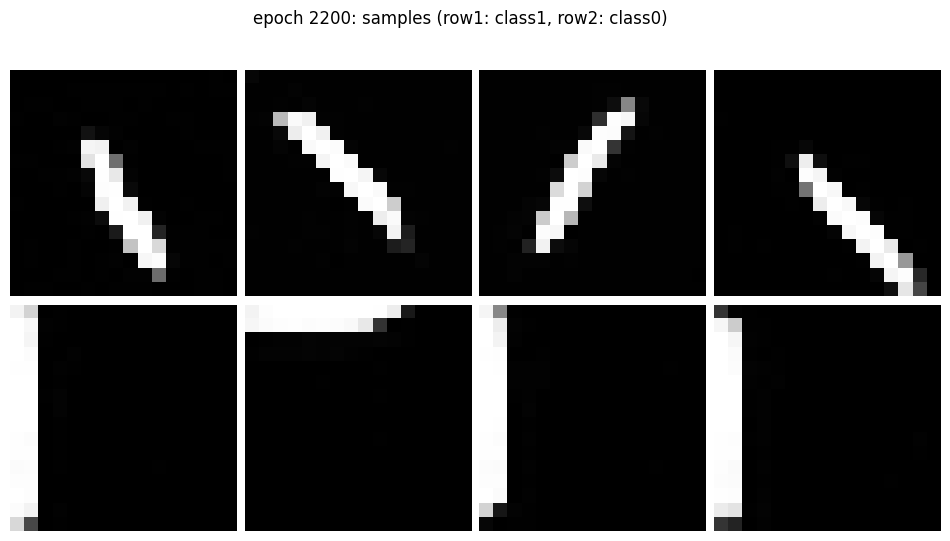

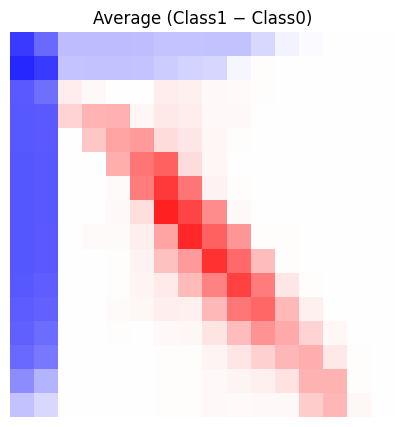

Epoch: 2250, loss: 0.2352
Epoch: 2300, loss: 0.2670
Best: loss=0.2128, epoch=2141
Epoch: 2350, loss: 0.2787
Epoch: 2400, loss: 0.2697
Best: loss=0.2128, epoch=2141


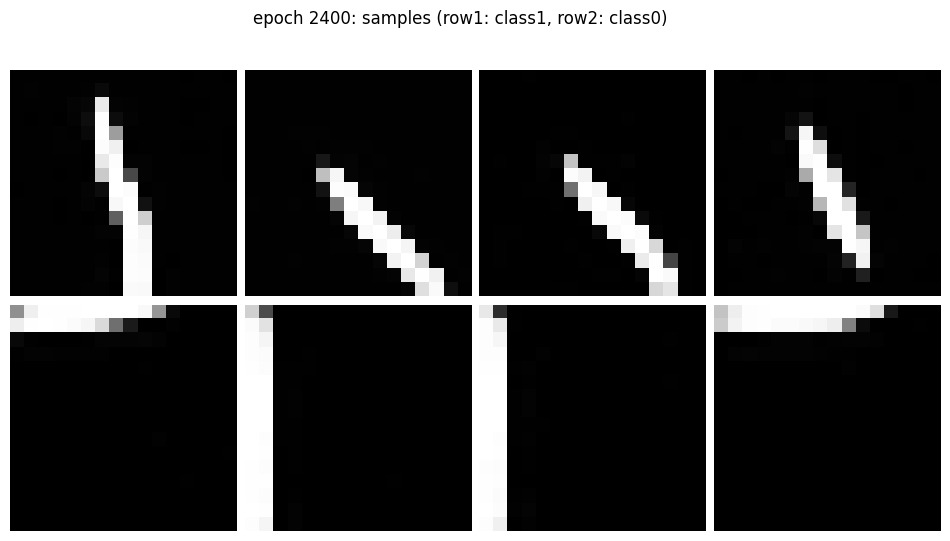

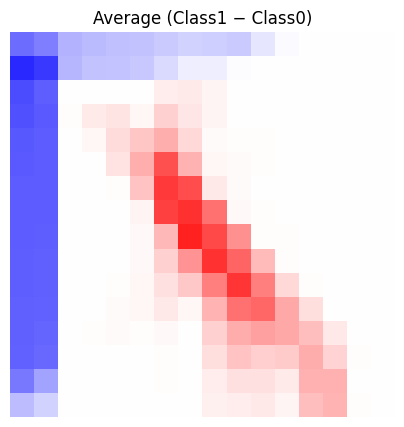

Epoch: 2450, loss: 0.2654
Epoch: 2500, loss: 0.2467
Best: loss=0.2128, epoch=2141
Epoch: 2550, loss: 0.2404
Epoch: 2600, loss: 0.2787
Best: loss=0.2098, epoch=2592


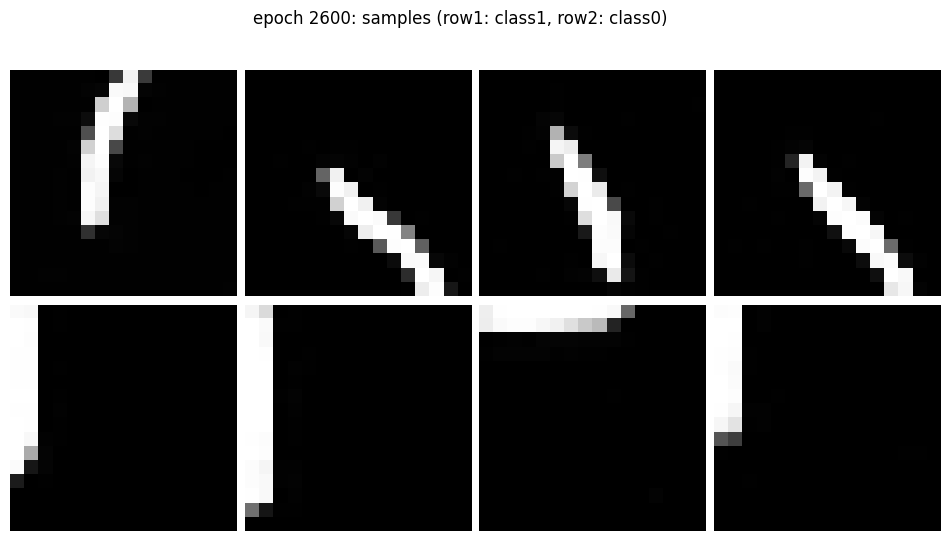

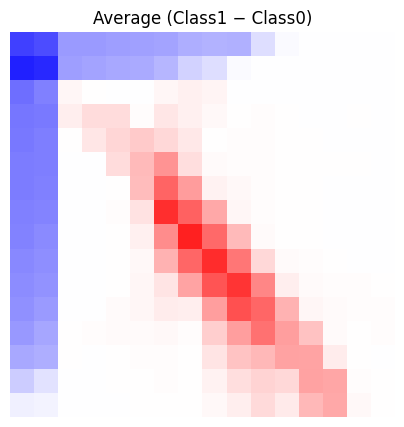

Epoch: 2650, loss: 0.2643
Epoch: 2700, loss: 0.2402
Best: loss=0.2098, epoch=2592
Epoch: 2750, loss: 0.2566
Epoch: 2800, loss: 0.2721
Best: loss=0.2058, epoch=2709


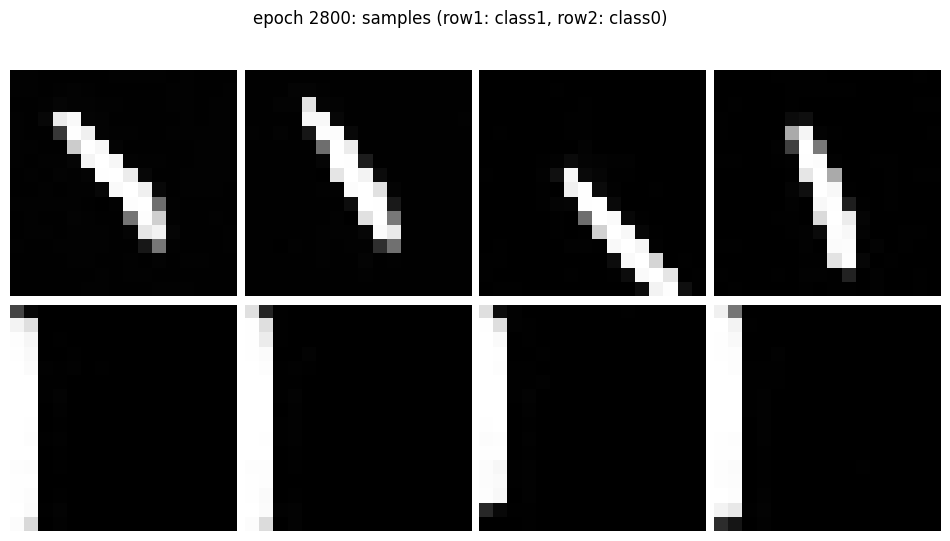

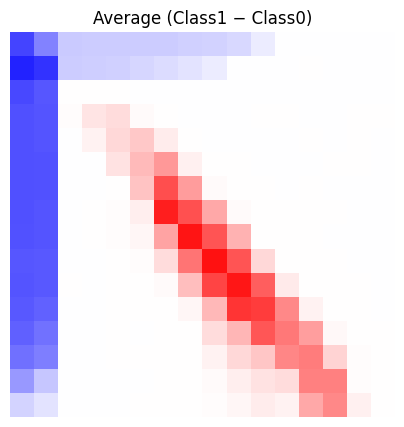

Epoch: 2850, loss: 0.2285
Epoch: 2900, loss: 0.2340
Best: loss=0.2058, epoch=2709
Epoch: 2950, loss: 0.2720

Training complete! Best epoch: 2709


In [11]:
import torch as tc

best_loss = float("inf")
best_epoch = 0
EPOCHS = 3000
INPUT_SIZE = 32
Tensor = torch.cuda.FloatTensor

training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    model.zero_grad()
    train_acc = 0
    t_epoch_loss = 0

    for (x, y) in train_loader:
        optimizer.zero_grad()

        # x = x.type(Tensor).to(device)
        # y = y.type(Tensor).to(device)

        ret_dict = model(x, y, generate_recon=False)

        loss = ret_dict['loss']
        t_epoch_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_acc += 1
        
    training_losses.append(t_epoch_loss / train_acc)

    loss_acc = 0
    val_acc = 0
    with torch.no_grad():
        for (x, y) in val_loader:
            # x = x.type(Tensor).to(device)
            # y = y.type(Tensor).to(device)

            ret_dict = model(x, y, generate_recon=False)

            loss_acc += ret_dict['loss'].item()
            val_acc += 1

    loss = loss_acc / val_acc
    validation_losses.append(loss)
    # Step the scheduler AFTER validation
    scheduler.step()

    if epoch % 50 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}')
    
    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch
        torch.save(model, "discrete_diffusion.pth")
    
    if epoch % 100 == 0:
        print(f'Best: loss={best_loss:.4f}, epoch={best_epoch}')
        
    if epoch % 200 == 0:
        model.eval()
        with torch.no_grad():
            # sample 4 lesions conditioned on y=1 and 4 on y=0
            y1 = torch.ones(128, device=device)
            y0 = torch.zeros(128, device=device)

            samples1 = model.p_sample_loop((128, 1, INPUT_SIZE, INPUT_SIZE), y1, temperature=1.2, cfg_scale=1.5)
            samples0 = model.p_sample_loop((128, 1, INPUT_SIZE, INPUT_SIZE), y0, temperature=1.2, cfg_scale=1.5)

            # ensure CPU numpy arrays [N, H, W]
            imgs1 = samples1.cpu().squeeze(1).numpy()
            imgs0 = samples0.cpu().squeeze(1).numpy()

            # average difference map (class1 - class0)
            avg1 = imgs1.mean(axis=0)
            avg0 = imgs0.mean(axis=0)
            diff_map = avg1 - avg0

        # plot: top row = 4 samples class1, bottom row = 4 samples class0
        fig = plt.figure(figsize=(12, 6))
        grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.08)
        for i in range(4):
            grid[i].imshow(imgs1[i], cmap='gray')
            grid[i].axis('off')
            grid[i+4].imshow(imgs0[i], cmap='gray')
            grid[i+4].axis('off')
        plt.suptitle(f'epoch {epoch}: samples (row1: class1, row2: class0)')
        plt.show()

        # difference map
        plt.figure(figsize=(5, 5))
        plt.imshow(diff_map, cmap='bwr', vmin=-1, vmax=1)
        plt.title('Average (Class1 − Class0)')
        plt.axis('off')
        plt.show()
        model.train()

print(f'\nTraining complete! Best epoch: {best_epoch}')

In [12]:
model = torch.load("discrete_diffusion.pth")

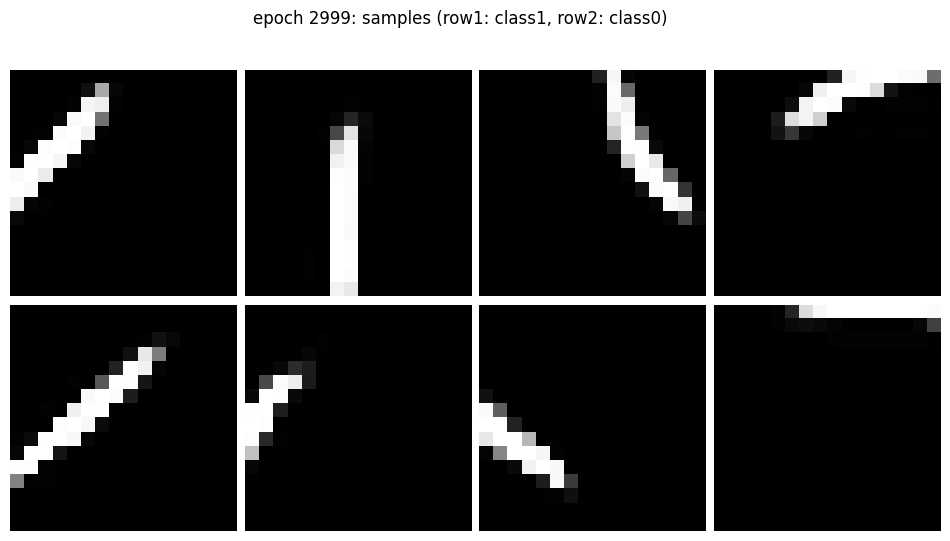

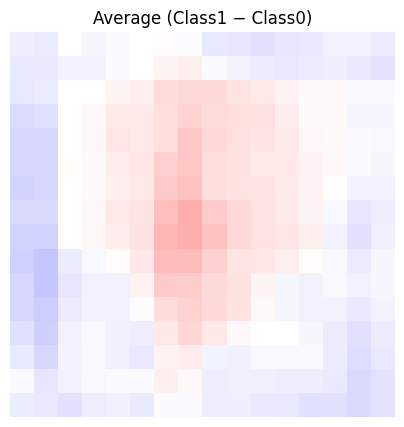

In [13]:
model.eval()
with torch.no_grad():
    # sample 4 lesions conditioned on y=1 and 4 on y=0
    y1 = torch.ones(2048, device=device)
    y0 = torch.zeros(2048, device=device)

    samples1 = model.p_sample_loop((2048, 1, INPUT_SIZE, INPUT_SIZE), y1, temperature=1, cfg_scale=1.3,
                                   dropout_during_inference=True)
    samples0 = model.p_sample_loop((2048, 1, INPUT_SIZE, INPUT_SIZE), y0, temperature=1, cfg_scale=1.3,
                                   dropout_during_inference=True
                                  )

    # ensure CPU numpy arrays [N, H, W]
    imgs1 = samples1.cpu().squeeze(1).numpy()
    imgs0 = samples0.cpu().squeeze(1).numpy()

    # average difference map (class1 - class0)
    avg1 = imgs1.mean(axis=0)
    avg0 = imgs0.mean(axis=0)
    vae_mask = avg1 - avg0
    # vae_mask = vae_mask - vae_mask.min()
    # vae_mask = vae_mask / vae_mask.max()

# plot: top row = 4 samples class1, bottom row = 4 samples class0
fig = plt.figure(figsize=(12, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.08)
for i in range(4):
    grid[i].imshow(imgs1[i], cmap='gray')
    grid[i].axis('off')
    grid[i+4].imshow(imgs0[i], cmap='gray')
    grid[i+4].axis('off')
plt.suptitle(f'epoch {epoch}: samples (row1: class1, row2: class0)')
plt.show()

# difference map
plt.figure(figsize=(5, 5))
plt.imshow(vae_mask, cmap='bwr', vmin=-1, vmax=1)
plt.title('Average (Class1 − Class0)')
plt.axis('off')
plt.show()

In [ ]:
vae_mask 

In [42]:
# model = torch.load("vae.pth")
# model.eval()
# vae_mask = np.load('vae_mask.npy')

# best_threshold = 0
# best_loss = 1e30

# threshold_range = np.linspace(0.85, 0.99, num=30)
# for thresh in threshold_range:
#     with torch.no_grad():
#         counter = 0
#         loss = 0
#         for (x, y) in cal_loader:
#             x = x.type(Tensor).to(device)
#             y = y.type(Tensor).to(device)
#             ret_dict = model(x, y,
#                              calibrate=True,
#                              t=float(thresh))

#             loss += ret_dict['loss']
#             counter += 1
#         loss = loss / counter
#         print(f'{thresh}, {loss}')
#         if loss < best_loss:
#             best_loss = loss
#             best_threshold = thresh
    
# # FIND THE BEST THRESHOLD
# t = np.quantile(vae_mask, best_threshold)

/tmp/ipykernel_36763/125185421.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("vae.pth")


AttributeError: Can't get attribute 'ModelWrapper' on <module '__main__'>

In [14]:
# RUN SVR-LSM APPROXIMATION FOR DEBUGGING PURPOSES
from sklearn import svm

# We're doing binary classification
continuous = False

svm_data = np.reshape(train_data, [train_data.shape[0], train_data.shape[2]**2])

svr_labels = train_labels
if continuous:
    svr_labels = (train_labels - train_labels.mean())
    svr_labels = svr_labels / svr_labels.std()
svm_data = svm_data / (np.linalg.norm(svm_data, axis=-1, keepdims=True) + 1e-5)

if continuous:
    svm = svm.SVR(kernel='rbf', C=0.8)
else:
    svm = svm.SVC(kernel='rbf')
svm.fit(svm_data, svr_labels)

alphas = svm.dual_coef_

backprojection = alphas * np.transpose(svm.support_vectors_)
backprojection = np.sum(backprojection, axis=1)
svm_preds = np.reshape(backprojection, [train_data.shape[2], train_data.shape[2]])
svm_preds.shape

(32, 32)

In [15]:
# RUN VLSM APPROXIMATION FOR DEBUGGING PURPOSES

idxs_p = np.where(train_labels > 0)
idxs_n = np.where(train_labels == 0)
img_size = 32

fisher_preds = np.zeros((img_size, img_size))
for i in range(img_size):
    for j in range(img_size):
        index_vox = train_data[:, 0, i, j]

        table = np.zeros((2, 2))
        table[0, 0] = np.sum(index_vox[idxs_n] == 0)
        table[0, 1] = np.sum(index_vox[idxs_n] > 0)
        table[1, 0] = np.sum(index_vox[idxs_p] == 0)
        table[1, 1] = np.sum(index_vox[idxs_p] > 0)

        p_value = scipy.stats.fisher_exact(table, 'greater')[-1]
        fisher_preds[i, j] = p_value

fisher_preds = - np.log(fisher_preds)
univar_preds = fisher_preds

In [16]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool_)
    im2 = np.asarray(im2).astype(np.bool_)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [17]:
best_threshold

0.8644827586206897

In [18]:

'''
THIS IS JUST FOR DEBUGGING PURPOSES
FOR PROPER EVALUATION YOU'LL HAVE TO GET P-VALUES FOR VLSM AND SVR-LSM 
AND THEN USE FWER/FDR
'''

results = {'VDVAE-LDM': vae_mask, 'VLSM': univar_preds, 'SVR-LSM': svm_preds}

keys = ['VDVAE-LDM', 'VLSM', 'SVR-LSM']
thresholds = {}
for k in keys:
    thresholds[k] = {'dice': [0, 0], 'hausdorff': [1e10, 0], 'asd': [1e10, 0],
                    }

for k in results:
    results[k] = results[k] - results[k].min()
    results[k] = results[k] / (results[k].max())

# threshold_range = np.linspace(0.8, 0.98, num=20)
threshold_range = [0.9]

for thresh in threshold_range:
    for k in thresholds:
        if k == 'VDVAE-LDM':
            t = np.quantile(results[k], best_threshold)
        else:
            t = np.quantile(results[k], thresh)
        bin_res = results[k] > t

        preds = np.expand_dims(np.expand_dims(results[k], axis=0), axis=0)
        bin_preds = np.expand_dims(np.expand_dims(bin_res, axis=0), axis=0)
        monai_gt = np.expand_dims(np.expand_dims(substrate, axis=0), axis=0)
        
        dice_s = dice(bin_res, substrate)
            
        if dice_s > thresholds[k]['dice'][0]:
            thresholds[k]['dice'][0] = round(dice_s, 2)
            if k == 'VDVAE-LDM':
                thresholds[k]['dice'][1] = best_threshold
            else:
                thresholds[k]['dice'][1] = thresh
            
            # haus = compute_hausdorff_distance(bin_preds, monai_gt).numpy()[0][0]
            # asd = compute_average_surface_distance(bin_preds, monai_gt,
            #                                        symmetric=False).numpy()[0][0]
            
#             thresholds[k]['hausdorff'][0] = round(haus, 2)
#             thresholds[k]['hausdorff'][1] = thresh
            
#             thresholds[k]['asd'][0] = round(asd, 2)
#             thresholds[k]['asd'][1] = thresh
            
            
thresholds

{'VDVAE-LDM': {'dice': [0.58, 0.8644827586206897],
  'hausdorff': [10000000000.0, 0],
  'asd': [10000000000.0, 0]},
 'VLSM': {'dice': [0.6, 0.9],
  'hausdorff': [10000000000.0, 0],
  'asd': [10000000000.0, 0]},
 'SVR-LSM': {'dice': [0.69, 0.9],
  'hausdorff': [10000000000.0, 0],
  'asd': [10000000000.0, 0]}}

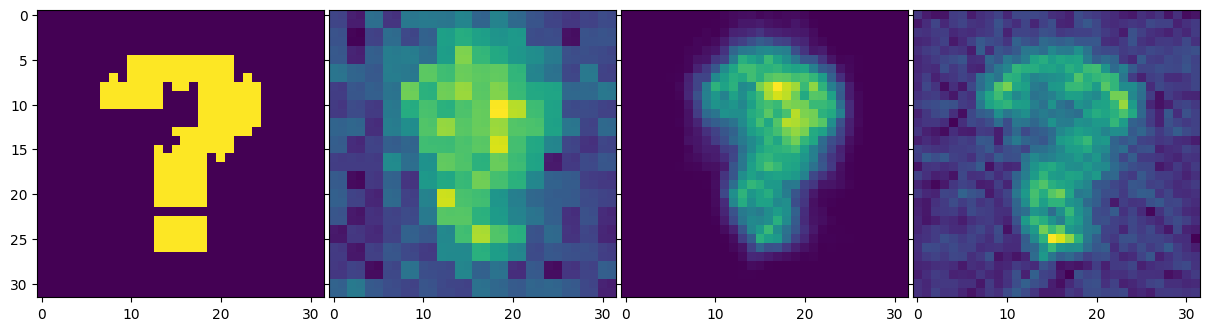

In [19]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(1, 4),
                 axes_pad=0.05,
                 share_all=True
                 )

grid[0].imshow(substrate)
grid[1].imshow(vae_mask)
grid[2].imshow(univar_preds)
grid[3].imshow(svm_preds)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ConditionalDiffusionLDM(nn.Module):
    """
    Conditional diffusion on binary lesion map x, conditioned on scalar y.
    Denoiser outputs lesion logits (2 channels).
    """
    def __init__(self,
                 input_size,
                 sd=16,
                 in_chans=1,
                 timesteps=100,
                 schedule='cosine'):
        super().__init__()
        self.in_chans = in_chans
        self.timesteps = timesteps
        self.input_size = input_size

        # schedule
        if schedule == 'cosine':
            alphas = self._cosine_schedule(timesteps)
        else:
            alphas = self._linear_schedule(timesteps)
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)

        # time embed
        self.time_embed_dim = sd * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(sd),
            nn.Linear(sd, self.time_embed_dim),
            nn.GELU(),
            nn.Linear(self.time_embed_dim, self.time_embed_dim),
        )

        # y embed (scalar or 1-d tensor). Produces same dim as time embedding.
        self.y_mlp = nn.Sequential(
            nn.Linear(1, self.time_embed_dim),
            nn.GELU(),
            nn.Linear(self.time_embed_dim, self.time_embed_dim),
        )

        # denoiser (U-Net-ish) -> outputs 2 channels (lesion logits)
        self._build_denoiser(in_chans, sd, self.time_embed_dim)

    def _cosine_schedule(self, timesteps, s=0.008):
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        alphas = alphas_cumprod[1:] / alphas_cumprod[:-1]
        return torch.clip(alphas, 0.001, 0.999)

    def _linear_schedule(self, timesteps, beta_start=0.0001, beta_end=0.02):
        betas = torch.linspace(beta_start, beta_end, timesteps)
        return 1.0 - betas

    def _build_denoiser(self, in_chans, sd, time_dim):
        channels = [in_chans, sd, sd*2, sd*4, sd*4]
        self.downs = nn.ModuleList([
            SBlock(channels[i], channels[i+1], downsample=True,
                   # add_coords=(i==0)
                   add_coords=False
                  )
            for i in range(len(channels)-1)
        ])
        self.time_proj = nn.ModuleList([
            nn.Sequential(nn.GELU(), nn.Linear(time_dim, channels[i+1]))
            for i in range(len(channels)-1)
        ])
        self.ups = nn.ModuleList([
            SBlock(channels[i+1] * 2, channels[i], upsample=True)
            for i in range(len(channels)-2, -1, -1)
        ])
        self.final_conv = nn.Conv2d(channels[0], 1, 1)  # binary problem

    def q_sample(self, x_0, t):
        """Forward (corruption) for binary lesion maps using per-pixel flip with keep prob alpha_t."""
        batch_size = x_0.shape[0]
        alpha_t = self.alphas_cumprod[t].view(batch_size, 1, 1, 1)
        alpha_t = torch.clamp(alpha_t, 0.0, 1.0)
        random_bits = torch.bernoulli(torch.ones_like(x_0) * 0.5)
        keep_probs = torch.clamp(alpha_t.expand_as(x_0), 0.0, 1.0)
        keep_mask = torch.bernoulli(keep_probs)

        x_t = x_0 * keep_mask + random_bits * (1 - keep_mask)
        return x_t

    def predict_x0(self, x_t, t, y):
        """
        Predict lesion logits from noisy x_t conditioned on y.
        y: tensor shape [B,] or [B,1] (scalar target); converted to float.
        """
        if y.dim() == 1:
            y = y.unsqueeze(1).float()
        t_emb = self.time_mlp(t)
        y_emb = self.y_mlp(y)
        cond_emb = t_emb + y_emb  # simple additive conditioning

        x = x_t
        skips = []
        for down, proj in zip(self.downs, self.time_proj):
            x = down(x)
            x = x + proj(cond_emb)[:, :, None, None]
            skips.append(x)

        for up in self.ups:
            x = torch.cat([x, skips.pop()], dim=1)
            x = up(x)

        output = self.final_conv(x)
        return output  # logits [B,1,H,W]

    def p_sample(self, x_t, t, y):
        """Single reverse step returning x_{t-1} approx (binary image)"""
        lesion_logits = self.predict_x0(x_t, t, y)
        x0_probs = F.sigmoid(lesion_logits)

        # final step
        if (t == 0).all():
            return x0_probs

        batch_size = x_t.shape[0]
        alpha_t = self.alphas_cumprod[t].view(batch_size, 1, 1, 1)
        alpha_t_minus_1 = self.alphas_cumprod[t-1].view(batch_size, 1, 1, 1)

        x0_probs = torch.clamp(x0_probs, 0.0, 1.0)
        x0_sample = torch.bernoulli(x0_probs)

        flip_prob = torch.clamp(1 - (alpha_t_minus_1 / alpha_t), 0.0, 1.0)
        flip_mask = torch.bernoulli(flip_prob.expand_as(x0_sample))
        x_t_minus_1 = x0_sample * (1 - flip_mask) + (1 - x0_sample) * flip_mask
        return x_t_minus_1

    @torch.no_grad()
    def p_sample_loop(self, shape, y):
        device = next(self.parameters()).device
        x = torch.bernoulli(torch.ones(shape, device=device) * 0.5)
        for i in reversed(range(self.timesteps)):
            t = torch.full((shape[0],), i, device=device, dtype=torch.long)
            x = self.p_sample(x, t, y)
        return x

    def forward(self, x, y, val=False, t=None, generate_recon=False):
        """
        x: binary lesion [B,1,H,W] (0/1)
        y: scalar condition [B] or [B,1]
        returns dict with losses and optional reconstructions
        """
        batch_size = x.shape[0]
        device = x.device

        # sample timestep
        t_diffusion = torch.randint(0, self.timesteps, (batch_size,), device=device).long()
        x_t = self.q_sample(x, t_diffusion)

        lesion_logits = self.predict_x0(x_t, t_diffusion, y)

        # logits_flat = lesion_logits.reshape(-1)
        # x_flat = x.reshape(-1)
        
        def dice_loss(pred_logits, target, eps=1e-6):
            pred = torch.sigmoid(pred_logits)
            num = 2*(pred*target).sum(dim=(1,2,3))
            den = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps
            return 1 - (num/den).mean()

            
        dice = dice_loss(lesion_logits, x)
        diffusion_loss = torch.mean(F.binary_cross_entropy_with_logits(lesion_logits, x))

        return {
            'loss': dice # + diffusion_loss
        }


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None].float() * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SBlock(nn.Module):
    def __init__(self, in_planes, planes, downsample=False, ks=3, stride=1, upsample=False, add_coords=False):
        super().__init__()
        self.downsample = downsample
        self.upsample = upsample
        if ks == 3:
            pad = 1
        elif ks == 5:
            pad = 2
        else:
            pad = 3
        if add_coords:
            in_planes += 2
        self.c1 = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=ks, stride=stride, padding=pad),
                                nn.BatchNorm2d(planes),
                                nn.GELU())
        self.upsample_layer = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        out = self.c1(x)
        if self.downsample:
            out = F.avg_pool2d(out, kernel_size=2, stride=2)
        if self.upsample:
            out = self.upsample_layer(out)
        return out
